In [30]:
import sklearn
from sklearn import *
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorly as tl
from tensorly import *
import scipy

In [4]:
path = "./data_3_variables/"
n_person = 10
n_view = 9
n_illum = 6
x_size = 200
y_size = 200

images = np.empty((n_person, n_view, n_illum, x_size, y_size))
for im_name in os.listdir(path):
    parsed = im_name.split("_")
    person = int(parsed[0])
    view   = int(-int(parsed[1])/4)
    illum  = int(int(parsed[4])/15)-1
    images[person, view, illum] = cv2.resize(cv2.imread( path+im_name, 0), (x_size, y_size))
# images = images.astype("uint8")

-----------------

In [41]:
def MPCA(T, n):
    """ Perform MPCA on the tensor T on the first n dimension of the tensor
        Returns (Z, U, U_T, S, V) where :
            Z is the core tensor
            U is the list of U matrices from the SVD
            U is the list of U^T matrices from the SVD
            S is the list of S matrices from the SVD
            V is the list of V matrices from the SVD
    """
    U = []
    U_T = []
    V = []
    S = []
    for i in range(n):
        u, s, v = np.linalg.svd(tl.base.unfold(T, i), full_matrices=False)
        U.append(u)
        U_T.append(u.T)
        S.append(s)
        V.append(v)
    return (tl.tenalg.multi_mode_dot(T, U_T, np.arange(n)), U, U_T, S, V)

In [6]:
Z, U, U_T, S, V = MPCA(images, 3)

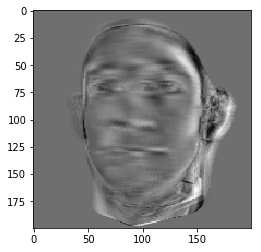

In [56]:
plt.imshow(Z[2,1,0], cmap="gray")

---------------

In [100]:
def MICA(T, n, fun="exp"):
    """ Perform MICA on the tensor T on the first n dimension of the tensor
    """
    Z, U, U_T, S, V = MPCA(T, n)
    W = []
    C = []
    C_1 = []
    for i in range(n):
        w = sklearn.decomposition.fastica_.fastica(tl.base.unfold(T, i), fun=fun)[1]
        W.append(w)
        c = np.dot(U[i], np.linalg.inv(w))
        C.append(c)
        C_1.append(np.linalg.inv(c))
    return tl.tenalg.multi_mode_dot(Z, W, np.arange(n))

In [101]:
S1 = MICA(images, 3)

/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


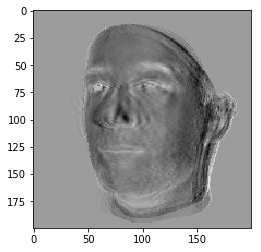

In [109]:
plt.imshow(S1[1,0,0], cmap="gray")

--------------------

#### Projection algorithm

In [19]:
d = images[0,0,0].reshape(-1)

In [11]:
Z2 = Z.reshape(10,9,6, -1)

In [13]:
Z3 = tl.unfold(Z2, 3)

In [14]:
P = np.linalg.pinv(Z3)

In [15]:
P.shape

(540, 40000)

In [16]:
P2 = tl.fold(P, 3, (10, 9, 6, 40000))

In [17]:
P2.shape

(10, 9, 6, 40000)

In [37]:
R = tl.tenalg.mode_dot(P2, d.reshape(1,-1), 3)

In [38]:
R.shape

(10, 9, 6, 1)

In [42]:
Z3, U3, U_T3, S3, V3 = MPCA(R, 3)

In [48]:
for u in U3:
    print(u[:,0])

[-0.25609421 -0.47869281 -0.28113334 -0.02094494 -0.37703519  0.06746543
 -0.49759798 -0.09329637 -0.43570524  0.18149423]
[-0.49766667  0.09686653  0.21303909  0.18079559  0.5526128  -0.32646512
 -0.13289571  0.37913327 -0.30250352]
[-0.43973579 -0.49346056 -0.23940394  0.26776837  0.39903346  0.52429693]


-----------------
#### Mode-m covarianc matrix

In [119]:
def mode_covariance_matrices(T):
    """ For a tensor T of order 4
        With T.shape = [n_person, n_view, n_illumination, n_pixel]
        Compute the 3 mode covariance matrices.
        Assuming that the mode 4 of T is the measurement mode. Pixel mode in our case
    """
    M = T.ndim
    Cov1 = np.zeros((T.shape[0], T.shape[0]))
    for j in range(T.shape[0]):
        for k in range(T.shape[0]):
            for i2 in range(T.shape[1]):
                for i3 in range(T.shape[2]):
                    Cov1[i,j] += T[j, i2, i3].reshape(1,-1).dot(T[k, i2, i3].reshape(-1,1))
    
    Cov2 = np.zeros((T.shape[1], T.shape[1]))
    for j in range(T.shape[1]):
        for k in range(T.shape[1]):
            for i1 in range(T.shape[0]):
                for i3 in range(T.shape[2]):
                    Cov2[i,j] += T[i1, j, i3].reshape(1,-1).dot(T[i1, k, i3].reshape(-1,1))
    
    Cov3 = np.zeros((T.shape[2], T.shape[2]))
    for j in range(T.shape[2]):
        for k in range(T.shape[2]):
            for i1 in range(T.shape[0]):
                for i2 in range(T.shape[1]):
                    Cov2[i,j] += T[i1, i2, j].reshape(1,-1).dot(T[i1, i2, k].reshape(-1,1))
    return [Cov1, Cov2, Cov3]

In [120]:
a = mode_covariance_matrices(Z.reshape(10,9,6, -1))
# Z.shape

NameError: name 'i' is not defined

In [114]:
print(a)

None
